In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import statsmodels.api as sm
from scipy import stats
import geopandas as gpd
import statsmodels.formula.api as smf

import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use("seaborn-v0_8") # pretty matplotlib plots


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hospital_cases_GMA.csv to hospital_cases_GMA.csv


In [ ]:
#file_path = 'C:/Users/Gaëlle/Documents/_CAS applied data science/2. Module 2 Statistical Inference for Data Science/Projet/hospital_cases.csv'

df = pd.read_csv('hospital_cases_GMA.csv')
column_names=df.columns.tolist()
column_names

['hospital',
 'canton',
 'delivery',
 'year',
 'cases_c-section',
 'cases_kidney',
 'Reg',
 'Uni',
 'percentage_c-section',
 'to_delete',
 'Doctor',
 'Doctor_in_formation',
 'Nurse',
 'Other_Nurse',
 'Total_staff',
 'Operation_rooms',
 'Delivery_rooms',
 'Private_division',
 'Beds']

# 1. Creation of a dependant variable which has a normal distibution

In [ ]:
# Our dependant variable is not normally distributed, we need to take the log to make it follow a normal distribution
df['log_y'] = np.log(df['percentage_c-section']*100)

In [ ]:
df.head()

,hospital,canton,delivery,year,cases_c-section,cases_kidney,Reg,Uni,percentage_c-section,to_delete,Doctor,Doctor_in_formation,Nurse,Other_Nurse,Total_staff,Operation_rooms,Delivery_rooms,Private_division,Beds,log_y
0,Les Hôpitaux Universitaires de Genève HUG,GE,4048,2015,1196.0,35.0,RO,1,0.295455,0,1676.08,NaN,4200.28,983.58,9936.21,38.0,7.0,0.0959,938.9,3.385930
1,LUKS Spitalbetriebe AG,LU,2988,2015,982.0,NaN,AL,0,0.328648,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.492402
2,CHUV Centre Hospitalier Universitaire Vaudois,VD,2909,2015,963.0,52.0,RO,1,0.331042,0,1586.90,NaN,3263.07,1578.87,9413.29,29.0,6.0,0.0726,888.0,3.499659
3,Universitätsspital Zürich,ZH,2839,2015,1226.0,83.0,AL,1,0.431842,0,1205.53,NaN,2207.53,1049.24,6431.54,34.0,8.0,0.2013,947.4,3.765475
4,Universitätsspital Basel,BS,2509,2015,912.0,80.0,AL,1,0.363491,0,877.81,NaN,1676.80,610.12,4764.80,24.0,5.0,0.2175,618.0,3.593171


## 1.1 Graphic

3.4707202417840897 0.24281597394912682


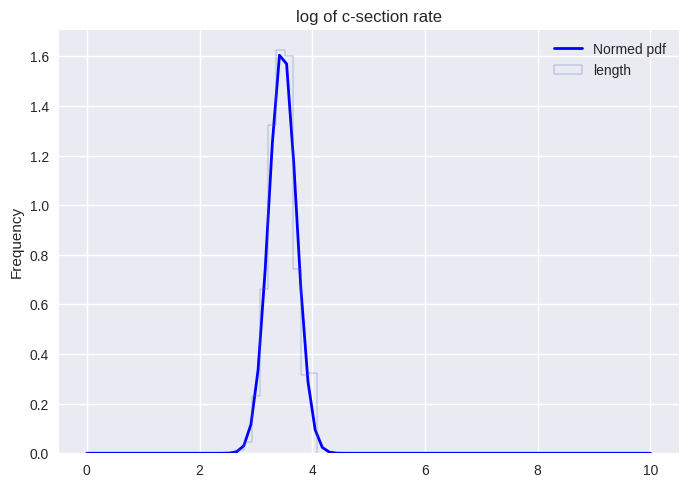

In [ ]:
from scipy.stats import norm  # This module "scipy.stats" contains a large number of probability distributions, summary and frequency statistics, correlation functions and statistical tests, masked statistics, kernel density estimation, quasi-Monte Carlo functionality, and more.
mean  = df['log_y'].mean()
width = df['log_y'].std()
print(mean,width)
# Create figure and axis
fig, ax = plt.subplots(1,1)
# Create 100 x values and plot the normal pdf for these values
#x = np.linspace(norm.ppf(0.01),norm.ppf(0.99), 100)
x = np.linspace(0,10,80)
ax.plot(x, norm.pdf(x,mean,width),'b-', lw=2, label='Normed pdf')
df['log_y'].plot(kind="hist",fill=False,histtype='step',title='log of c-section rate', label="length", density="True")
ax.legend(loc='best', frameon=False)
plt.show()

## 1.2 D'Agostino-Pearson test

In [ ]:
# Other normality test
k2, p = stats.normaltest(df['log_y']) # D Agostino-Pearson. The method returns the test statistic value and the p-value
alpha = 0.001 # Rejection criterion defined by you
print('Alpha = ',alpha)
print('p = ',p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
  print("The null hypothesis cannot be rejected")

Alpha =  0.001
p =  0.41580923696623917
The null hypothesis cannot be rejected


In [ ]:
# Both from the graphic and the D'Agostino-Pearson test, we can conclude that the log of the c-section rates is a variable that follow a normal distribution

# 2. Regression

## 2.0 Get the data ready

In [ ]:
# Dummy for kidney: assumption: kidney transplant is a heavy operation so hospitals that perform heavy operations also perform more c-sections
df['kidney_dum'] = df['cases_kidney'].apply(lambda x: 1 if x > 0 else 0)

# Dummy for the region (1: french speaking canton, 0: german speaking canton). No need to create a dummy for the University hospitals, it is already 1-0
df['region_dum'] = df['Reg'].apply(lambda x: 1 if x == 'RO' else 0)

# We need to normalize the number of doctors, nurses and staff
df['doc_bed'] = df['Doctor']/df['Beds']
df['nurse_bed'] = df['Nurse']/df['Beds']
df['staff_bed'] = df['Total_staff']/df['Beds']
df['operat_bed'] = df['Operation_rooms']/df['Beds']
df['deliv_bed'] = df['Delivery_rooms']/df['Beds']

In [ ]:
column_names=df.columns.tolist()
column_names

['hospital',
 'canton',
 'delivery',
 'year',
 'cases_c-section',
 'cases_kidney',
 'Reg',
 'Uni',
 'percentage_c-section',
 'to_delete',
 'Doctor',
 'Doctor_in_formation',
 'Nurse',
 'Other_Nurse',
 'Total_staff',
 'Operation_rooms',
 'Delivery_rooms',
 'Private_division',
 'Beds',
 'log_y',
 'kidney_dum',
 'region_dum',
 'doc_bed',
 'nurse_bed',
 'staff_bed',
 'operat_bed',
 'deliv_bed']

## 2.1 Model 1: all the variables

In [ ]:
model_1 = smf.ols('log_y ~ kidney_dum +year+ region_dum + Uni + doc_bed +nurse_bed+ staff_bed+operat_bed+deliv_bed+Private_division', data=df).fit()

# Variables that are significant (P.value smaller than 0.05):
#region_dum
#Private_division
#Operation_rooms
#Delivery_rooms

# year and intercept are significant but at 90% CI

#model = smf.ols('log_y ~ Operation_rooms + Private_division', data=df).fit()

In [ ]:
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     43.56
Date:                Thu, 05 Oct 2023   Prob (F-statistic):           2.65e-61
Time:                        16:58:08   Log-Likelihood:                 156.76
No. Observations:                 495   AIC:                            -291.5
Df Residuals:                     484   BIC:                            -245.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -23.7612      8.556  

## 2.2 Model with only the significant variables

In [ ]:
model_2 = smf.ols('log_y ~ kidney_dum+year+region_dum+Uni+staff_bed+Private_division+operat_bed+deliv_bed', data=df).fit()


In [ ]:
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_y   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     53.18
Date:                Thu, 05 Oct 2023   Prob (F-statistic):           1.11e-61
Time:                        16:58:08   Log-Likelihood:                 153.53
No. Observations:                 495   AIC:                            -289.1
Df Residuals:                     486   BIC:                            -251.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -23.0277      8.588  

# 2.3 Diagnostic plots

In [ ]:
df.head()

,hospital,canton,delivery,year,cases_c-section,cases_kidney,Reg,Uni,percentage_c-section,to_delete,...,Private_division,Beds,log_y,kidney_dum,region_dum,doc_bed,nurse_bed,staff_bed,operat_bed,deliv_bed
0,Les Hôpitaux Universitaires de Genève HUG,GE,4048,2015,1196.0,35.0,RO,1,0.295455,0,...,0.0959,938.9,3.385930,1,1,1.785153,4.473618,10.582820,0.040473,0.007456
1,LUKS Spitalbetriebe AG,LU,2988,2015,982.0,NaN,AL,0,0.328648,0,...,NaN,NaN,3.492402,0,0,NaN,NaN,NaN,NaN,NaN
2,CHUV Centre Hospitalier Universitaire Vaudois,VD,2909,2015,963.0,52.0,RO,1,0.331042,0,...,0.0726,888.0,3.499659,1,1,1.787050,3.674628,10.600552,0.032658,0.006757
3,Universitätsspital Zürich,ZH,2839,2015,1226.0,83.0,AL,1,0.431842,0,...,0.2013,947.4,3.765475,1,0,1.272461,2.330093,6.788621,0.035888,0.008444
4,Universitätsspital Basel,BS,2509,2015,912.0,80.0,AL,1,0.363491,0,...,0.2175,618.0,3.593171,1,0,1.420405,2.713269,7.710032,0.038835,0.008091


In [ ]:
X = df[['year', 'region_dum', 'Uni', 'staff_bed', 'operat_bed', 'deliv_bed', 'Private_division', 'kidney_dum']]


y = pd.DataFrame(df['log_y'])

# generate OLS model (which is model_2 above)
model = smf.ols('log_y ~ kidney_dum+year+ region_dum + Uni + staff_bed+operat_bed+deliv_bed+Private_division', data=df)
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
dataframe = pd.concat([X, y], axis=1)




## 2.3.1 Residuals vs Fitted

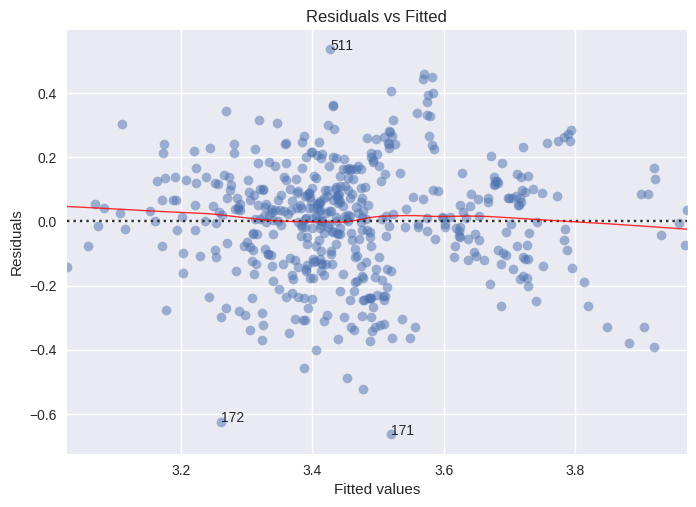

In [ ]:
  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]
  tmp = pd.concat([model_fitted_y, model_residuals], axis=1, keys=['fitted', 'residuals'])


  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(data=tmp, x='fitted', y='residuals',
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

plot_lm_1.savefig("Diagnostic_residuals_vs_fitted.png")

In [ ]:
# This graph shows if there are any nonlinear patterns in the residuals, and thus in the data as well.
# An ideal Residuals vs Fitted plot will look like random noise; there won’t be any apparent patterns in the scatterplot
# and the red line would be horizontal.

### 2.3.2 QQ plot

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


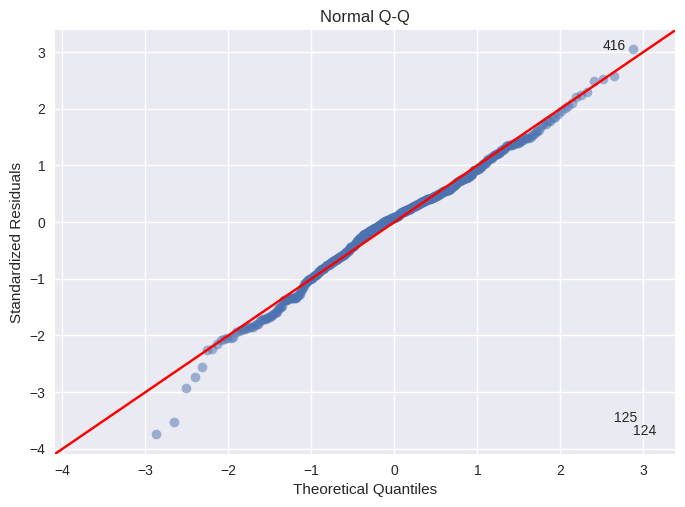

In [ ]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#c7bbc9', lw=1)#4C72B0
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

plot_lm_2.savefig("Diagnostic_qqplot.png")

In [ ]:
# A good normal QQ plot has all of the residuals lying on or close to the red line.
# Looking at the graph above, there are several points that fall far away from the red line.
# This is indicative of the errors not being normally distributed, in fact our model suffers from “heavy tails”.

# What does this say about the data? We are more likely to see extreme values than to be expected if the data was truly normally distributed.


## 2.3.2 Scale-Location

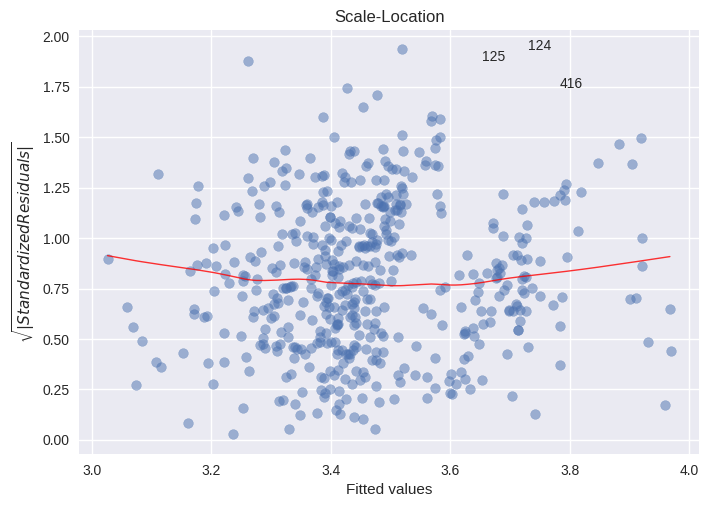

In [ ]:
# This plot is a way to check if the residuals suffer from non-constant variance, aka heteroscedasticity.
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
tmp2 = pd.DataFrame(model_norm_residuals_abs_sqrt, columns = ['model_norm_residuals_abs_sqrt'])
tmp3 = pd.concat([model_fitted_y, tmp2], axis=1, keys=['fitted', 'residuals_normed'])
sns.regplot(data=tmp3, x='fitted', y='residuals_normed',
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                               xy=(model_fitted_y[i],
                                   model_norm_residuals_abs_sqrt[i]));

plot_lm_3.savefig("Diagnostic_scale_location.png")

In [ ]:
# The more horizontal the red line is, the more likely the data is homoscedastic.
# We clearly have homoscedasticity. This might be caused by not capturing the non-linearities in the model (see Residuals vs Fitted plot)

## 2.3.4 Residuals vs Leverage

In [ ]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

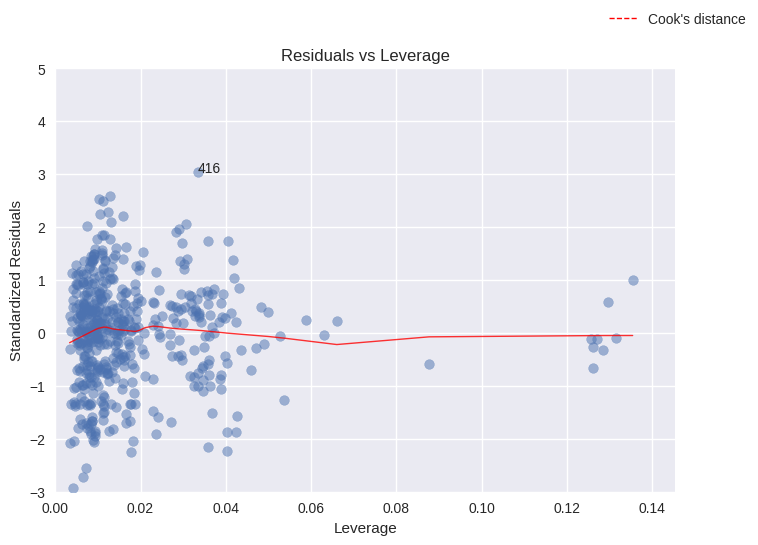

In [ ]:
  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  tmp4 = pd.DataFrame(model_leverage, columns = ['model_leverage'])
  tmp5 = pd.DataFrame(model_norm_residuals, columns = ['model_norm_residuals'])
  tmp6 = pd.concat([tmp4, tmp5], axis=1, keys=['leverage', 'residuals_normed'])
  sns.regplot(data=tmp6, x='leverage', y='residuals_normed',
             scatter=False,
             ci=False,
             lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');

plot_lm_4.savefig("Diagnostic_residuals_vs_leverage.png")

In [ ]:
# Thanks to Cook’s Distance, we only need to find leverage points that have a distance greater than 0.5.
# In this plot, we do not have any leverage points that meet this criteria.
